In [1]:
#! /usr/bin/env python3
# -*- coding: utf-8 -*-

# Численные методы решения скалярного СДУ с сильным порядком сходимости

Иллюстрация работы функций из модуля (пока просто одного файла) `sde`

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import threading as thr
import sde

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (13.0, 6.0)
rcParams['font.size'] = 18

### Численный метод Эйлера-Маруйамы
Решаем скалярное СДУ:
\begin{equation}
    x(t) = f(x,t)\mathrm{d}t + g(x,t)\mathrm{d}W
\end{equation}
численным методом Эйлера-Маруйамы:
\begin{equation}
    x_{n+1} = f(x_n,t_n)h_{n} + g(x_{n},t_{n})\Delta W_{n}
\end{equation} 

### Аппроксимирование кратных интегралов Ито

Следующие кратные интегралы выражаются через приращения винеровского процесса в конечном виде:
\begin{align}
    &I^{(1)}_{n} = \Delta W_{n},\\
    &I^{(1,1)}_{n} = \frac12 (\Delta W_{n})^2  - \frac12 h,\\
    &I^{(1,0)}_{n} = \frac12 (\Delta W_{n} + \frac{1}{\sqrt{3}}\zeta_{n}),\\
    &I^{(1,1,1)}_{n} = \frac16 \left( (I^{(1,1)})^3 - 3h\Delta W_{n} \right). 
\end{align}
эти интегралы вычисляются функциями `Ito1W1(dW)`, `Ito2W1(dW, h)` и `Ito3W1(dW, h)`. Для стохастического метода Рунге-Кутты сильного порядка $p=1.5$ в случае скалярного винеровского процесса кроме этих интегралов никакие другие вычислять не нужно.

###Стохастические методы Рунге-Кутты сильного порядка $p=1,5$

Численная схема стохастического метода Рунге-Кутты с сильным порядком $p=1.5$ стадийностью $s$ выглядит следующим образом:

\begin{align}
	&X^{(0)}_{i} = x_{n} + \sum\limits_{j=1}^{s}A^{(0)}_{ij}f(X^{(0)}_{j})h_{n} + \sum\limits_{j=1}^{s}B^{(0)}_{ij}g(X^{(1)}_{j})\dfrac{I_{(1,0)}}{h_{n}},\;\; i =1,\ldots,s\\
	&X^{(1)}_{i} = x_{n} + \sum\limits_{j=1}^{s}A^{(1)}_{ij}f(X^{(0)}_{j})h_{n} + \sum\limits_{j=1}^{s}B^{(1)}_{ij}g(X^{(1)}_{j})\sqrt{h_{n}},\;\; i =1,\ldots,s\\
	&x_{n+1} = x_{n} + \sum\limits_{i=1}^{s}a_{i}f(X^{(0)}_{i})h_{n} + \sum\limits_{i=1}^{s}\left(b^{(1)}_{i}I_{(1)} + b^{(2)}_{i}\dfrac{I_{(1,1)}}{\sqrt{h_{n}}} + b^{(3)}_{i}\dfrac{I_{(1,0)}}{h_{n}} + b^{(4)}_{i}\dfrac{I_{(1,1,1)}}{h_{n}}\right)g(X^{(1)}_{i}),\;\; n=1,\ldots,N
\end{align}

\begin{equation}
	{\renewcommand{\arraystretch}{1.5}%
	\begin{array}{c|c|c|c}
		\mathbf{c}^{(0)} & \mathbf{A}^{(0)} & \mathbf{B}^{(0)} &\\ \hline
		\mathbf{c}^{(1)} & \mathbf{A}^{(1)} & \mathbf{B}^{(1)} &\\ \hline
		& \mathbf{a}^{T} & \mathbf{b}^{(1)T} & \mathbf{b}^{(2)T}\\ \hline
		&  & \mathbf{b}^{(3)T} & \mathbf{b}^{(4)T}\\
	\end{array}}
\end{equation}

## Пример использования численных методов для решения СДУ

Будем решать численно СДУ:
\begin{equation}
    \mathrm{d}x(t) = \mu x(t) \mathrm{d}t + \sigma x(t) \mathrm{d}W(t),\;\; x(0) = x_{0}.
\end{equation}
Это уравнение носит название *логорифмического блуждания* и имеет точное решение:
\begin{equation}
    x(t) = x_0 \exp{\left((\mu - 0.5\sigma^2)t + \sigma W(t)\right)}
\end{equation}
Параметры выберем следующие: $\mu = 2,\; \sigma = 1$, а начальное значени $ x_{0} = 1$.

In [4]:
def f(x):
    """Вектор сноса"""
    μ = 2
    return μ*x

def g(x):
    """Диффузия"""
    σ = 1
    return σ*x


def exact_solution(x_0, t, W):
    """Точное решение СДУ"""
    μ = 2
    σ = 1
    return x_0*np.exp((μ - 0.5*σ**2)*t + σ*W)

Временной промежуток $[t_{0},T] = [0,1]$. Разбиваем его на $N$ частей с шагом $(T-t_{0})/N$. У функции `sde.wiener_process()` по умолчанию как раз такие значения параметров.

In [5]:
T = 1.0
N = 10**3
x_0 = 1

In [6]:
(dt, t, dW, W) = sde.wiener_process(N)

Проведем теперь вычиления с помощью численного метода Эйлера-Маруйамы, стохастических численных методов Рунге-Кутты и с помощью формулы для точного решения. После этого сразу построим графики.

In [7]:
x_num_euler = sde.EulerMaruyama(f, g, dt, x_0, dW)
x_num_srk1 = sde.strongSRKW1(f, g, dt, x_0, dW, name='SRK1W1')
x_num_srk2 = sde.strongSRKW1(f, g, dt, x_0, dW, name='SRK2W1')
x_num_klpl = sde.strongSRKW1(f, g, dt, x_0, dW, name='KlPl')
x = exact_solution(x_0, t, W)

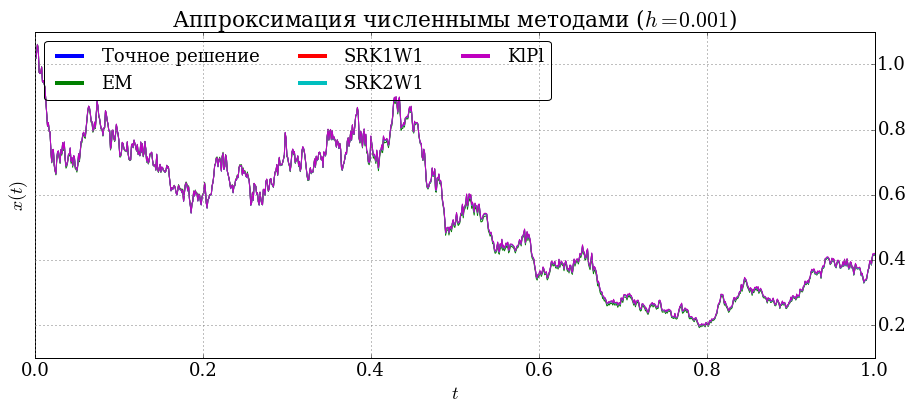

In [8]:
fig = plt.figure(0)
ax = fig.add_subplot(1,1,1)

ax.set_title("Аппроксимация численнымы методами ($h={0}$)".format(dt))
ax.set_xlabel('$t$')
ax.set_ylabel('$x(t)$')

ax.yaxis.tick_right()

ax.plot(t,x,lw=1.0,label='Точное решение')
ax.plot(t,x_num_euler, lw=1.0, label='EM')
ax.plot(t,x_num_srk1, lw=1.0, label='SRK1W1')
ax.plot(t,x_num_srk2, lw=1.0, label='SRK2W1')
ax.plot(t,x_num_klpl, lw=1.0, label='KlPl')

#ax.set_ylim([6.0,8.0])
#ax.set_xlim([0.9,1.0])

ax.legend(ncol=3, loc='upper left')

for line in ax.get_legend().get_lines():
    line.set_linewidth(4.0)
    
fig.tight_layout()

## Вычисление сильной локальной погрешности

Для вычисления сильной локальной погрешности, надо для каждого шага вычислить математическое ожидание. Для этого проводим несколько вычислительных эксперементов т.е.

- генерируем траекторию процесса Винера;
- для этой траектории пычисляем точное решение и приближенные решения с помощью численных методов;
- находим локальную ошибку $|x - x_{n}|$;
- генерируем новую траеторию и проводим те же вычисления для нее;
- повторяем `sim_nums` раз;
- по завершению для каждого метода получаем двухмерных массив локальной погрешности `[N,sim_num]`
- вычисляем среднее арифметическое по второй размерности и получаем `N` чисел, каждое из которых будет сильной локальной погрешностью в каждой точке траектории. 

In [9]:
# проводим 100 эксперементов
sim_nums = np.arange(0,100,1)

errors_euler = np.empty((N,len(sim_nums)))
errors_klpl = np.empty((N,len(sim_nums)))   # Kloeden an Platen
errors_srk1 = np.empty((N,len(sim_nums)))
errors_srk2 = np.empty((N,len(sim_nums)))

def simulation(sim_nums):
    for sim_num in sim_nums:
        (dt, t, dW, W) = sde.wiener_process(N)

        x = exact_solution(x_0, t, W)
        x_num_euler = sde.EulerMaruyama(f, g, dt, x_0, dW)
        x_num_srk1 = sde.strongSRKW1(f, g, dt, x_0, dW, name='SRK1W1')
        x_num_srk2 = sde.strongSRKW1(f, g, dt, x_0, dW, name='SRK2W1')
        x_num_klpl = sde.strongSRKW1(f, g, dt, x_0, dW, name='KlPl')
        
        err = np.abs(x - x_num_euler)
        errors_euler[:,sim_num] = err

        err = np.abs(x - x_num_srk1)
        errors_srk1[:,sim_num] = err

        err = np.abs(x - x_num_srk2)
        errors_srk2[:,sim_num] = err
        
        err = np.abs(x - x_num_klpl)
        errors_klpl[:,sim_num] = err

Запускаем вычисления в многопоточном режиме

In [10]:
# Распределяем работу между нитями
ths = [] # Нити
for part in np.split(sim_nums, 5):
    ths.append(thr.Thread(target=simulation, args=(part,)))

for th in ths:
    th.start()
for th in ths:
    th.join()

## Сравнение сильных локальных погрешностей

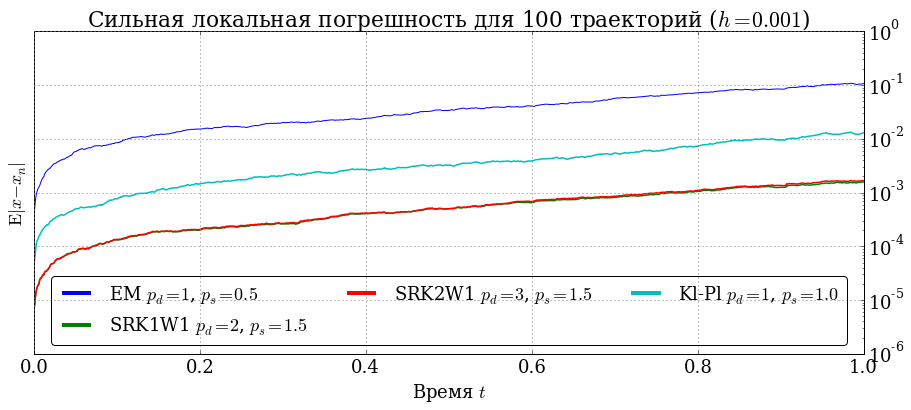

In [11]:
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(1,1,1)

ax1.set_title("Сильная локальная погрешность для {0} траекторий ($h={1}$)".format(len(sim_nums),dt))
ax1.set_ylabel(r"$\mathrm{E}|x-x_{n}|$")
ax1.set_xlabel("Время $t$")

ax1.set_yscale('log')
ax1.yaxis.tick_right()
# Вычисляем среднее арифметическое прямо внутри plot методом .mean
ax1.plot(t,errors_euler.mean(axis=1), lw=1.0, label = 'EM $p_{d}=1$, $p_{s} = 0.5$')
ax1.plot(t,errors_srk1.mean(axis=1), lw=1.5, label = 'SRK1W1 $p_{d}=2$, $p_{s} = 1.5$')
ax1.plot(t,errors_srk2.mean(axis=1), lw=1.5, label = 'SRK2W1 $p_{d}=3$, $p_{s} = 1.5$')
ax1.plot(t,errors_klpl.mean(axis=1), lw=1.5, label = 'Kl-Pl $p_{d}=1$, $p_{s} = 1.0$')

ax1.legend(ncol=3, loc='lower center')
 
for line in ax1.get_legend().get_lines():
    line.set_linewidth(4.0)
fig1.tight_layout()

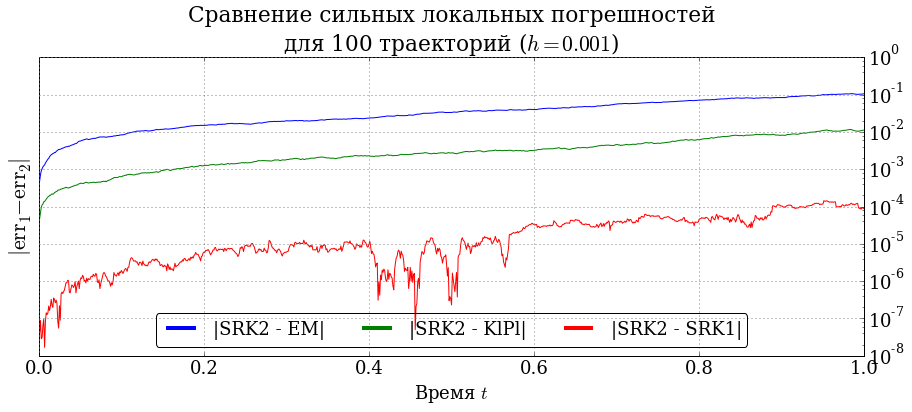

In [12]:
fig2 = plt.figure(2)
ax2 = fig2.add_subplot(1,1,1)

ax2.set_title("Сравнение сильных локальных погрешностей\nдля {0} траекторий ($h={1}$)".format(len(sim_nums),dt))
ax2.set_ylabel(r"$|\mathrm{err}_{1}-\mathrm{err}_{2}|$", fontsize=22)
ax2.set_xlabel("Время $t$")

ax2.set_yscale('log')
ax2.yaxis.tick_right()
# Вычисляем среднее арифметическое прямо внутри plot методом .mean
ax2.plot(t, np.abs(errors_srk2.mean(axis=1)-errors_euler.mean(axis=1)), lw=1.0, label = '|SRK2 - EM|')
#ax2.plot(t, np.abs(errors_klpl.mean(axis=1)-errors_euler.mean(axis=1)), lw=1.0, label = '|KlPl - EM|')
ax2.plot(t, np.abs(errors_srk2.mean(axis=1)-errors_klpl.mean(axis=1)), lw=1.0, label = '|SRK2 - KlPl|')
ax2.plot(t, np.abs(errors_srk2.mean(axis=1)-errors_srk1.mean(axis=1)), lw=1.0, label = '|SRK2 - SRK1|')

ax2.legend(ncol=3, loc='lower center')

for line in ax2.get_legend().get_lines():
    line.set_linewidth(4.0)

fig2.tight_layout()